In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
import pandas as pd 

from scipy import optimize
from scipy import integrate

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns


sns.set(style="darkgrid")

mpl.rcParams['figure.figsize'] = (16, 16)
pd.set_option('display.max_rows', 500)


In [2]:
# - We are trying to fit the data to our SIR model. 
# - We first pass our differential equation to fit_ideint which gives us a function
# - We then use curve fit to get best value to optimize that function i.e. we get best beta and Gamma 
# - we then use our Beta, gamma and data for each country to plot the curve,
# - the curve is two part, time vs truth and time vs fitted
# - We are trying to fit the data to our SIR model. 
# - We first pass our differential equation to fit_ideint which gives us a function
# - We then use curve fit to get best value to optimize that function i.e. we get best beta and Gamma 
# - we then use our Beta, gamma and data for each country to plot the curve,
# - the curve is two part, time vs truth and time vs fitted
# try to parse the dates right at the beginning 
# it works out of the box if the date was stored ISO YYYY-MM-DD format

df_analyse=pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';')  
df_analyse.sort_values('date',ascending=True).head()


def getCountryValues(country):
    df=pd.read_csv('../data/processed/COVID_relational_confirmed.csv',sep=';')

    grouped_df = df.groupby("country")

    df["sum_column"] = grouped_df[["confirmed"]].transform(sum)


    df = df.sort_values("sum_column", ascending=False)


    country_list = df['country'].unique().tolist()

    df = df.drop("sum_column", axis=1)


    grouped_df = df.groupby("country")

    final_sorted_values = grouped_df.get_group(country).sort_values("date", ascending=True)
    
    return final_sorted_values, country_list


_, country_list = getCountryValues('Germany')


for each in country_list[:2]:
    df,_ = getCountryValues(each)
    print(df)

             date state country  confirmed
252    2020-01-22    no      US        1.0
518    2020-01-23    no      US        1.0
784    2020-01-24    no      US        2.0
1050   2020-01-25    no      US        2.0
1316   2020-01-26    no      US        5.0
1582   2020-01-27    no      US        5.0
1848   2020-01-28    no      US        5.0
2114   2020-01-29    no      US        5.0
2380   2020-01-30    no      US        5.0
2646   2020-01-31    no      US        7.0
2912   2020-02-01    no      US        8.0
3178   2020-02-02    no      US        8.0
3444   2020-02-03    no      US       11.0
3710   2020-02-04    no      US       11.0
3976   2020-02-05    no      US       11.0
4242   2020-02-06    no      US       11.0
4508   2020-02-07    no      US       11.0
4774   2020-02-08    no      US       11.0
5040   2020-02-09    no      US       11.0
5306   2020-02-10    no      US       11.0
5572   2020-02-11    no      US       12.0
5838   2020-02-12    no      US       12.0
6104   2020

In [3]:
# print(country_list)

In [4]:
# set some basic parameters
# beta/gamma is denoted as  'basic reproduction number'

N0=50000000 #max susceptible population
beta=0.4   # infection spread dynamics
gamma=0.1  # recovery rate


# condition I0+S0+R0=N0
I0=df_analyse.Germany[35]
S0=N0-I0
R0=0

In [5]:
def SIR_model(SIR,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return([dS_dt,dI_dt,dR_dt])


# Simulative approach to calculate SIR curves

In [6]:

SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})



for each_t in np.arange(100):
   
    new_delta_vec=SIR_model(SIR,beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)


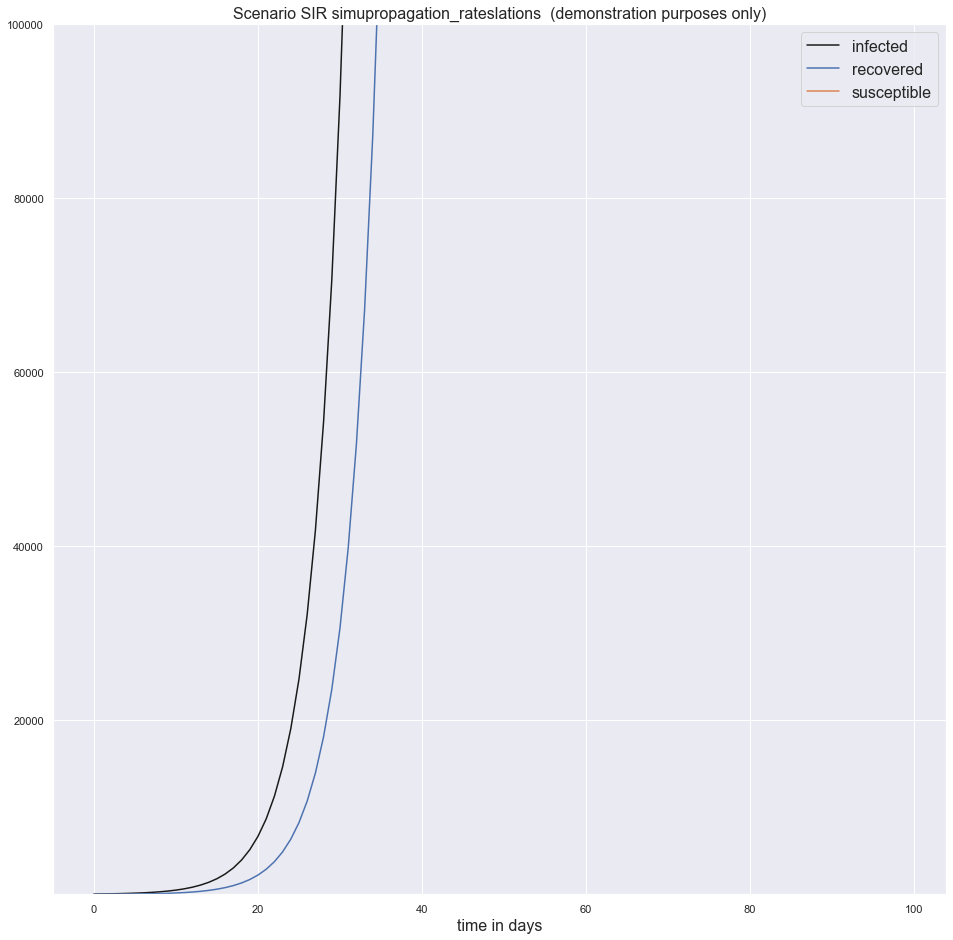

In [7]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='infected',color='k')
ax1.plot(propagation_rates.index,propagation_rates.recovered,label='recovered')
ax1.plot(propagation_rates.index,propagation_rates.susceptible,label='susceptible')

ax1.set_ylim(10, 100000)
ax1.set_yscale('linear')
ax1.set_title('Scenario SIR simupropagation_rateslations  (demonstration purposes only)',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best',
           prop={'size': 16});

# Part(1 of 2) DashBoard 1 (Dynamic Simulation only, without Free Parameters)

# Fitting the parameters of SIR model




In [8]:
def SIR_model_t(SIR,t,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        t: time step, mandatory for integral.odeint
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt



def fit_odeint(x, beta, gamma):
    '''
    helper function for the integration
    '''
    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,1] # we only would like to get dI


In [9]:
# print(options)

In [10]:
country_list = ['US', 'Brazil', 'India', 'Russia', 'Spain', 'United Kingdom', 'Italy', 'Peru', 'Iran', 'Mexico', 'France', 'Germany', 'Chile', 'South Africa', 'Turkey', 'Pakistan', 'Saudi Arabia', 'Colombia', 'China', 'Bangladesh', 'Canada', 'Argentina', 'Qatar', 'Belgium', 'Indonesia', 'Ecuador', 'Sweden', 'Iraq', 'Netherlands', 'Egypt', 'Philippines', 'Belarus', 'Ukraine', 'United Arab Emirates', 'Portugal', 'Kuwait', 'Kazakhstan', 'Singapore', 'Israel', 'Oman', 'Switzerland', 'Dominican Republic', 'Bolivia', 'Panama', 'Poland', 'Romania', 'Ireland', 'Japan', 'Bahrain', 'Afghanistan', 'Nigeria', 'Guatemala', 'Armenia', 'Austria', 'Honduras', 'Ghana', 'Serbia', 'Algeria', 'Korea, South', 'Azerbaijan', 'Morocco', 'Moldova', 'Denmark', 'Czechia', 'Kyrgyzstan', 'Australia', 'Uzbekistan', 'Cameroon', 'Nepal', 'Norway', 'Kenya', 'Venezuela', 'Malaysia', "Cote d'Ivoire", 'Ethiopia', 'El Salvador', 'Costa Rica', 'Finland', 'Sudan', 'Bosnia and Herzegovina', 'Senegal', 'Bulgaria', 'North Macedonia', 'Luxembourg', 'Congo (Kinshasa)', 'West Bank and Gaza', 'Guinea', 'Tajikistan', 'Madagascar', 'Gabon', 'Haiti', 'Hungary', 'Greece', 'Kosovo', 'Djibouti', 'Croatia', 'Thailand', 'Mauritania', 'Albania', 'Paraguay', 'Lebanon', 'Zambia', 'Central African Republic', 'Maldives', 'Cuba', 'Somalia', 'Equatorial Guinea', 'Estonia', 'Iceland', 'Lithuania', 'Slovenia', 'Slovakia', 'Sri Lanka', 'Nicaragua', 'Libya', 'Mali', 'New Zealand', 'Malawi', 'Congo (Brazzaville)', 'South Sudan', 'Guinea-Bissau', 'Tunisia', 'Zimbabwe', 'Montenegro', 'Cabo Verde', 'Latvia', 'Eswatini', 'Sierra Leone', 'Cyprus', 'Diamond Princess', 'Niger', 'Uruguay', 'Rwanda', 'Burkina Faso', 'Jordan', 'Mozambique', 'Andorra', 'Georgia', 'Benin', 'Namibia', 'Yemen', 'Malta', 'Suriname', 'San Marino', 'Uganda', 'Chad', 'Jamaica', 'Liberia', 'Togo', 'Sao Tome and Principe', 'Zambia', 'Angola', 'Tanzania', 'Vietnam', 'Syria', 'Mauritius', 'Botswana', 'Gambia', 'Bahamas', 'Burma', 'Guyana', 'Lesotho', 'Comoros', 'Trinidad and Tobago', 'Mongolia', 'Cambodia', 'Burundi', 'Brunei', 'Eritrea', 'Monaco', 'Barbados', 'Liechtenstein', 'Belize', 'Bhutan', 'Seychelles', 'Antigua and Barbuda', 'Papua New Guinea', 'Saint Vincent and the Grenadines', 'Timor-Leste', 'Grenada', 'Fiji', 'Saint Lucia', 'Laos', 'Dominica', 'Saint Kitts and Nevis', 'Holy See', 'MS Zaandam', 'Western Sahara']

In [11]:
options = []
t = 1
ydata = 1
SIR_of_countries ={}
time = {}

import plotly.graph_objects as go
import plotly
plotly.__version__

country_list = ['US', 'Brazil', 'India', 'Russia', 'Spain', 'United Kingdom', 'Italy', 'Peru', 'Iran', 'Mexico', 'France', 'Germany', 'Chile', 'South Africa', 'Turkey', 'Pakistan', 'Saudi Arabia', 'Colombia', 'China', 'Bangladesh', 'Canada', 'Argentina', 'Qatar', 'Belgium', 'Indonesia', 'Ecuador', 'Sweden', 'Iraq', 'Netherlands', 'Egypt', 'Philippines', 'Belarus', 'Ukraine', 'United Arab Emirates', 'Portugal', 'Kuwait', 'Kazakhstan', 'Singapore', 'Israel', 'Oman', 'Switzerland', 'Dominican Republic', 'Bolivia', 'Panama', 'Poland', 'Romania', 'Ireland', 'Japan', 'Bahrain', 'Afghanistan', 'Nigeria', 'Guatemala', 'Armenia', 'Austria', 'Honduras', 'Ghana', 'Serbia', 'Algeria', 'Korea, South', 'Azerbaijan', 'Morocco', 'Moldova', 'Denmark', 'Czechia', 'Kyrgyzstan', 'Australia', 'Uzbekistan', 'Cameroon', 'Nepal', 'Norway', 'Kenya', 'Venezuela', 'Malaysia', "Cote d'Ivoire", 'Ethiopia', 'El Salvador', 'Costa Rica', 'Finland', 'Sudan', 'Bosnia and Herzegovina', 'Senegal', 'Bulgaria', 'North Macedonia', 'Luxembourg', 'Congo (Kinshasa)', 'West Bank and Gaza', 'Guinea', 'Tajikistan', 'Madagascar', 'Gabon', 'Haiti', 'Hungary', 'Greece', 'Kosovo', 'Djibouti', 'Croatia', 'Thailand', 'Mauritania', 'Albania', 'Paraguay', 'Lebanon', 'Zambia', 'Central African Republic', 'Maldives', 'Cuba', 'Somalia', 'Equatorial Guinea', 'Estonia', 'Iceland', 'Lithuania', 'Slovenia', 'Slovakia', 'Sri Lanka', 'Nicaragua', 'Libya', 'Mali', 'New Zealand', 'Malawi', 'Congo (Brazzaville)', 'South Sudan', 'Guinea-Bissau', 'Tunisia', 'Zimbabwe', 'Montenegro', 'Cabo Verde', 'Latvia', 'Eswatini', 'Sierra Leone', 'Cyprus', 'Diamond Princess', 'Niger', 'Uruguay', 'Rwanda', 'Burkina Faso', 'Jordan', 'Mozambique', 'Andorra', 'Georgia', 'Benin', 'Namibia', 'Yemen', 'Malta', 'Suriname', 'San Marino', 'Uganda', 'Chad', 'Jamaica', 'Liberia', 'Togo', 'Sao Tome and Principe', 'Zambia', 'Angola', 'Tanzania', 'Vietnam', 'Syria', 'Mauritius', 'Botswana', 'Gambia', 'Bahamas', 'Burma', 'Guyana', 'Lesotho', 'Comoros', 'Trinidad and Tobago', 'Mongolia', 'Cambodia', 'Burundi', 'Brunei', 'Eritrea', 'Monaco', 'Barbados', 'Liechtenstein', 'Belize', 'Bhutan', 'Seychelles', 'Antigua and Barbuda', 'Papua New Guinea', 'Saint Vincent and the Grenadines', 'Timor-Leste', 'Grenada', 'Fiji', 'Saint Lucia', 'Laos', 'Dominica', 'Saint Kitts and Nevis', 'Holy See', 'MS Zaandam', 'Western Sahara']

for each in country_list:
    d = {}
    d['label'] = each
    d['value'] = each

    options.append(d)
    
    ydata = np.array(df_analyse[each][35:])    
    t=np.arange(len(ydata))

    # ensure re-initialization 
    I0=ydata[0]
    S0=N0-I0
    R0=0
    beta


    # example curve of our differential equation
    popt=[0.4,0.1]
    fit_odeint(t, *popt) # we get the function using this and then we give the function to curve fit, to get
                         # best value of beta and gamma

    # the resulting curve has to be fitted
    # free parameters are here beta and gamma

    popt, pcov = optimize.curve_fit(fit_odeint, t, ydata, maxfev=5000)    
    perr = np.sqrt(np.diag(pcov))

#     print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
#     print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
    

#     get the final fitted curve
    fitted=fit_odeint(t, *popt)
    
    
#     plt.semilogy(t, ydata, 'o')
#     plt.semilogy(t, fitted)
#     plt.title("Fit of SIR model for "+each +" cases")
#     plt.ylabel("Population infected")
#     plt.xlabel("Days")
#     plt.show()
#     print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
#     print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
#     print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")
    
    
    fig = go.Figure()
    SIR_of_countries[each] = fitted
    time[each] = t
    
    fig.add_trace(go.Scatter(x=pd.Series(t),
                                y=pd.Series(df_analyse[each]),
                                mode='markers+lines',
                                opacity=0.9,
                                line_width=2,
                                marker_size=4, 
                                name=each
                                 )
                     )
    
    fig.add_trace(go.Scatter(x=pd.Series(t),
                                y=pd.Series(fitted),
                                mode='lines',
                                opacity=0.9,
                                line_width=2,
                                marker_size=4, 
                                name=each + ' Predicted'
                             )
                     )    
    
    
    

/Users/test/.local/lib/python3.7/site-packages/scipy/integrate/odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/test/.local/lib/python3.7/site-packages/scipy/integrate/odepack.py:236: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning:

overflow encountered in double_scalars

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning:

overflow encountered in double_scalars

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning:

overflow encountered in double_scalars

/Users/test/.local/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning:

Covariance of the parameters could not be estimated

/opt/anac

In [12]:
import dash
dash.__version__
import dash_core_components as dcc
import dash_html_components as html

app = dash.Dash()
app.layout = html.Div([
    
    html.Label('Multi-Select Country'),
    
    dcc.Dropdown(
        id='country_drop_down',
        options= options,
        value=['US', 'Spain'], # which are pre-selected
        multi=True
    ),   
        
    dcc.Graph(figure=fig, id='main_window_slope')
])

from dash.dependencies import Input, Output

@app.callback(
    Output('main_window_slope', 'figure'),
    [Input('country_drop_down', 'value')])
def update_figure(country_list):    
    traces = [] 
    for each in country_list:        
        traces.append(dict(x=pd.Series(time[each]),
                                y=pd.Series(df_analyse[each]),
                                mode='markers+lines',
                                opacity=0.9,
                                line_width=2,
                                marker_size=4, 
                                name=each
                        )
                )        
        
        traces.append(dict(x=pd.Series(time[each]),
                                y=pd.Series(SIR_of_countries[each]),
                                mode='lines',
                                opacity=0.9,
                                line_width=2,
                                marker_size=4, 
                                name=each + ' Predicted'
                        )
                )        
        
    return {
            'data': traces,
            'layout': dict (
                width=1280,
                height=720,
                xaxis_title="Time",
                yaxis_title="SIR Curve)",
                xaxis={'tickangle':-45,
                        'nticks':20,
                        'tickfont':dict(size=14,color="#7f7f7f"),
                        
                      },
                yaxis={'type':"log",
                       'range':'[1.1,7.5]'
                      }
        )
    }

In [ ]:
app.run_server(debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8050/

 in production, use a production WSGI server like gunicorn instead.

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
